In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras import optimizers
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#!pip list

Using TensorFlow backend.


## 1. Upload and Clean Dataset

In [2]:
#data can be downloaded here https://www.figure-eight.com/data-for-everyone/
raw_data = pd.read_csv('/Users/benjamin.jones/Desktop/Disaster Tweets/socialmedia-disaster-tweets-DFE.csv', encoding='latin-1')
raw_data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


**extract only the necessary columns**

In [3]:
data = raw_data[['choose_one','text']]
data.head()

,choose_one,text
0,Relevant,Just happened a terrible car crash
1,Relevant,Our Deeds are the Reason of this #earthquake M...
2,Relevant,"Heard about #earthquake is different cities, s..."
3,Relevant,"there is a forest fire at spot pond, geese are..."
4,Relevant,Forest fire near La Ronge Sask. Canada


**quick exploroatary analysis. checking for:**  

**1. empty rows**  
**2. unique labels**

In [4]:
data.isna().sum()

choose_one    0
text          0
dtype: int64

In [5]:
data['choose_one'].describe()

count            10876
unique               3
top       Not Relevant
freq              6187
Name: choose_one, dtype: object

In [6]:
set(data['choose_one'])

{"Can't Decide", 'Not Relevant', 'Relevant'}

**remove "can't decide" label so output is binary** 

In [7]:
data = data[data['choose_one']!="Can't Decide"]


**double check labels are now binary** 

In [8]:
set(data['choose_one'])

{'Not Relevant', 'Relevant'}

**convert labels to 0 for not disaster and 1 for disaster**

In [9]:
data['label'] = 0
data.loc[data.choose_one == 'Relevant', 'label'] = 1
data.pop('choose_one')

0        Relevant
1        Relevant
2        Relevant
3        Relevant
4        Relevant
           ...   
10871    Relevant
10872    Relevant
10873    Relevant
10874    Relevant
10875    Relevant
Name: choose_one, Length: 10860, dtype: object

### **We have a total sample size of 10,860 with 57% non-disaster and 43% disaster**

In [10]:
data['label'].value_counts()

0    6187
1    4673
Name: label, dtype: int64

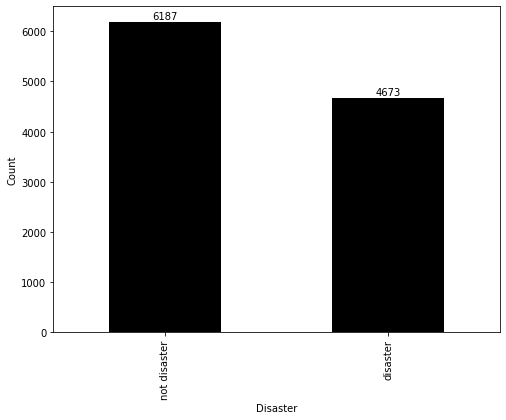

In [11]:
plt.figure(figsize=(8, 6))
ax = pd.Series(data['label'].value_counts()).plot(kind='bar', color='black') #raw, data values
ax.set_xlabel('Disaster')
ax.set_ylabel('Count')
ax.set_xticklabels(['not disaster', 'disaster'])

labels = data['label'].value_counts() #raw data values to be used as chart labels
rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

In [12]:
data = data.sample(frac=1) #shuffle for good measure
data.head()

,text,label
1602,@BrodyFrieling @hanna_brooksie photo bombed,0
7648,@brokenscnecal I just though about panic! at t...,0
5532,Flattened thee striker,1
3695,As I catch the last few minutes. Finally Monwa...,0
7839,Reddit updates content policy promises to quar...,0


### 1.1 Split into Training/Validation

**Here we will use 75% of the dataset for training and 25% for validation (testing). It is also important to consider the distribution of each label. In this case, we have 6,187 non-disaster cases and 4,673 disaster cases. Since we have roughly the same amount of both labels, we won't need to do anything further (but we will double check to be safe).**

**Note: it is quite likely in other scenarios to have imbalanced data. For example, you may have data for a rare genetic disease. Perhaps only 5% of the dataset contains positive cases for this disease while 95% are negative. In situations like this, it is important that both the training and vaildation sets have the same distribution of lables (%5 positive and 95% neagtive).**

In [13]:
#convert dataframe into arrays, the format to use for ANN
x = data.iloc[:,0].values #inputs
y = data.iloc[:,1].values #labels

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25) #25% for validation, 75% for training

**As you can see below, both the training and validation set have about the same balance of disaster and non-disaster cases, so no further action is needed.**

In [15]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Training Set")
print(np.asarray((unique_elements, counts_elements)))
print(round(counts_elements[0]/(sum(counts_elements))*100,2), "% 0 (not disaster)")
print(round(100-(counts_elements[0]/(sum(counts_elements))*100),2), "% 1 (disaster)")

Training Set
[[   0    1]
 [4680 3465]]
57.46 % 0 (not disaster)
42.54 % 1 (disaster)


In [16]:
unique_elements, counts_elements = np.unique(y_val, return_counts=True)
print("Validation Set")
print(np.asarray((unique_elements, counts_elements)))
print(round(counts_elements[0]/(sum(counts_elements))*100,2), "% 0 (not disaster)")
print(round(100-(counts_elements[0]/(sum(counts_elements))*100),2), "% 1 (disaster)")

Validation Set
[[   0    1]
 [1507 1208]]
55.51 % 0 (not disaster)
44.49 % 1 (disaster)


## 2 Model

### 2.1 Set up Model Saving

In [17]:
#save the model at this location after every epoch
checkpoint_path = '/Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints/cp-{epoch:04d}' #unique name for each saved checkpoint (after every 1 epoch)
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                                save_freq='epoch' #save after every epoch
                                                )
latest = tf.train.latest_checkpoint(checkpoint_dir) #returns file name of latest checkpoint
print(latest)

/Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints/cp-0020


In [18]:
#Optional: load a saved model
#model.load_weights(latest) #loads weights of the most reccent saved model (adjust if latest not desired)

### 2.2 Embedding Vectors

**This is a learned, vector (numerical) representation for text where words that have similar meaning are represented similarly. We can use a pre-trained text embedding as the first layer, which will have three advantages:**

**1. we don't have to worry about text preprocessing**  
**2. we can benefit from transfer learning**  
**3. the embedding has a fixed size, so it's simpler to process**  

**We'll use a pre-trained text embedding model from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1).**  

**Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that no matter the length of the input text, the output shape of the embeddings is: (num_examples, embedding_dimension)**

In [19]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(data['text'][:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 0.28795514, -0.33089155,  0.4694359 ,  0.25962555, -0.3899307 ,
         0.519044  ,  0.02347763,  0.20918302,  0.40586933,  0.15561381,
        -0.5326305 ,  0.4416759 , -0.209601  , -0.14638771,  0.4305011 ,
        -0.34971237, -0.6025258 , -0.24149889, -0.37806344,  0.29764125],
       [ 0.3428518 , -1.2258928 ,  1.1127486 , -0.09706269, -1.6098815 ,
        -2.0234637 , -1.4268725 ,  0.89119524,  1.8129581 ,  0.74163836,
        -1.5837238 ,  0.5597518 ,  0.7064632 , -0.06522568, -1.801542  ,
         0.95429164,  1.0367122 , -0.57998896, -1.228939  , -0.07077654],
       [-0.7684545 , -0.3240194 , -0.4590403 , -0.78238493, -0.6346923 ,
         0.84253484,  0.3933478 ,  0.3958523 , -0.12424278,  0.36349782,
        -0.243992  , -0.09113774,  0.36228633, -0.17937404,  0.5450773 ,
         0.85830885,  0.44275758, -0.47713774, -0.7886732 ,  0.7035698 ]],
      dtype=float32)>

### 2.3 Full Model

#### 2.3.1 Model Framework
**the layers are stacked sequentially to build the classifier** . 

**1. the first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The pre-trained text embedding model that we are using (google/tf2-preview/gnews-swivel-20dim/1) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: (num_examples, embedding_dimension).**

**2. this fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.**

**3. the last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.**

In [20]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


#### 2.3.1 Compile the Model
**define learning paramaters (exactly which algorithm will the mode use to learn?)**

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 2.3.1 Training

In [22]:
#begin or resume training
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=32,
                    epochs=30,
                    validation_data=(x_val, y_val),
                    shuffle=True,
                    verbose=1,
                   callbacks=[cp_callback])

Train on 8145 samples, validate on 2715 samples
Epoch 1/30
8032/8145 [============================>.] - ETA: 0s - loss: 0.6049 - accuracy: 0.6846
Epoch 00001: saving model to /Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints/cp-0001
8145/8145 [==============================] - 1s 150us/sample - loss: 0.6046 - accuracy: 0.6853 - val_loss: 0.5247 - val_accuracy: 0.7466
Epoch 2/30
7488/8145 [==========================>...] - ETA: 0s - loss: 0.4980 - accuracy: 0.7666
Epoch 00002: saving model to /Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints/cp-0002
8145/8145 [==============================] - 1s 92us/sample - loss: 0.4958 - accuracy: 0.7681 - val_loss: 0.4961 - val_accuracy: 0.7683
Epoch 3/30
8064/8145 [============================>.] - ETA: 0s - loss: 0.4529 - accuracy: 0.7953
Epoch 00003: saving model to /Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints/cp-0003
8145/8145 [==============================] - 1s 94us/sample - loss: 0.4542 - accuracy: 0.7946 - val_

Epoch 26/30
7648/8145 [===========================>..] - ETA: 0s - loss: 0.0633 - accuracy: 0.9727
Epoch 00026: saving model to /Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints/cp-0026
8145/8145 [==============================] - 1s 91us/sample - loss: 0.0640 - accuracy: 0.9725 - val_loss: 1.1688 - val_accuracy: 0.7543
Epoch 27/30
7712/8145 [===========================>..] - ETA: 0s - loss: 0.0599 - accuracy: 0.9735
Epoch 00027: saving model to /Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints/cp-0027
8145/8145 [==============================] - 1s 90us/sample - loss: 0.0618 - accuracy: 0.9726 - val_loss: 1.1881 - val_accuracy: 0.7565
Epoch 28/30
7584/8145 [==========================>...] - ETA: 0s - loss: 0.0616 - accuracy: 0.9730
Epoch 00028: saving model to /Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints/cp-0028
8145/8145 [==============================] - 1s 91us/sample - loss: 0.0619 - accuracy: 0.9729 - val_loss: 1.2228 - val_accuracy: 0.7624
Epoch 29/3

## 3 Evaluation

**Clearly this model is overfitting.**

In [23]:
model.evaluate(x_val, y_val, verbose=1) #[validation loss, validation accuracy]

2715/2715 [==============================] - 0s 35us/sample - loss: 1.2825 - accuracy: 0.7551


[1.2824509734826413, 0.7550644]

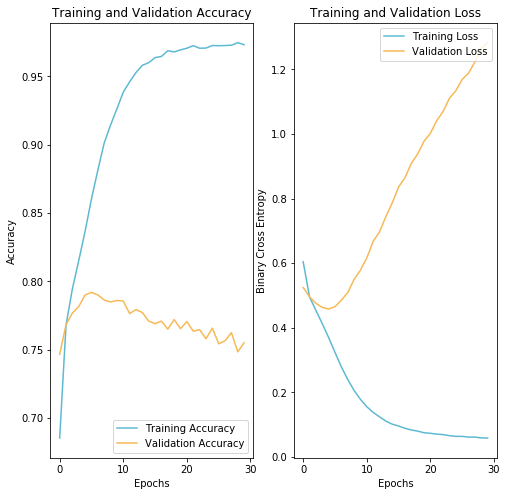

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

#plot aesthetics
color_train = '#5DB9D2'
color_val = '#F6B956'

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color=color_train)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color=color_val)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color=color_train)
plt.plot(epochs_range, val_loss, label='Validation Loss', color=color_val)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epochs')
plt.show()

## 4 Adjustments

**regularizers, dropout, increased batch size**

In [26]:
from tensorflow.keras import regularizers
#save the model at this location after every epoch
checkpoint_path2 = '/Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints 2/cp-{epoch:04d}' #unique name for each saved checkpoint (after every 1 epoch)
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path2,
                                                save_weights_only=True,
                                                verbose=1,
                                                save_freq='epoch' #save after every epoch
                                                )

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) optional

#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) optional for different optimizer
model2 = tf.keras.Sequential()
model2.add(hub_layer)
model2.add(tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(1))
model2.summary()

model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#begin or resume training
history2 = model2.fit(x=x_train,
                    y=y_train,
                    batch_size=650,
                    epochs=30,
                    validation_data=(x_val, y_val),
                    shuffle=True,
                    verbose=1,
                   callbacks=[cp_callback2])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                336       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________
Train on 8145 samples, validate on 2715 samples
Epoch 1/30
5200/8145 [==================>...........] - ETA: 0s - loss: 0.8523 - accuracy: 0.5158
Epoch 00001: saving model to /Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints 2/cp-0001
814

Epoch 23/30
5200/8145 [==================>...........] - ETA: 0s - loss: 0.2497 - accuracy: 0.8948
Epoch 00023: saving model to /Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints 2/cp-0023
8145/8145 [==============================] - 0s 19us/sample - loss: 0.2552 - accuracy: 0.8894 - val_loss: 0.5165 - val_accuracy: 0.7827
Epoch 24/30
5200/8145 [==================>...........] - ETA: 0s - loss: 0.2436 - accuracy: 0.8921
Epoch 00024: saving model to /Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints 2/cp-0024
8145/8145 [==============================] - 0s 18us/sample - loss: 0.2422 - accuracy: 0.8956 - val_loss: 0.5233 - val_accuracy: 0.7849
Epoch 25/30
5200/8145 [==================>...........] - ETA: 0s - loss: 0.2336 - accuracy: 0.8994
Epoch 00025: saving model to /Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints 2/cp-0025
8145/8145 [==============================] - 0s 18us/sample - loss: 0.2345 - accuracy: 0.8993 - val_loss: 0.5309 - val_accuracy: 0.7845
Epoc

**Comparison of Model 1 and Model 2**

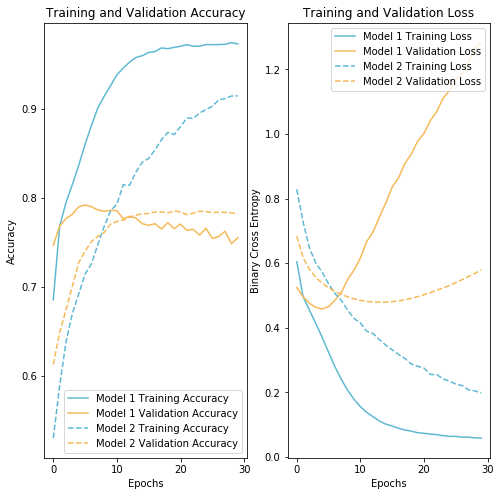

In [28]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Model 1 Training Accuracy', color=color_train)
plt.plot(epochs_range, val_acc, label='Model 1 Validation Accuracy', color=color_val)
plt.plot(epochs_range, acc2, label='Model 2 Training Accuracy', color=color_train, linestyle='dashed')
plt.plot(epochs_range, val_acc2, label='Model 2 Validation Accuracy', color=color_val, linestyle='dashed')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Model 1 Training Loss', color=color_train)
plt.plot(epochs_range, val_loss, label='Model 1 Validation Loss', color=color_val)
plt.plot(epochs_range, loss2, label='Model 2 Training Loss', color=color_train, linestyle='dashed')
plt.plot(epochs_range, val_loss2, label='Model 2 Validation Loss', color=color_val, linestyle='dashed')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epochs')
plt.show()

In [37]:
model1_best = tf.keras.Sequential()
model1_best.add(hub_layer)
model1_best.add(tf.keras.layers.Dense(16, activation='relu'))
model1_best.add(tf.keras.layers.Dense(1))

model1_best.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model1_best.load_weights('/Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints/cp-0005')
model1_best.evaluate(x_val, y_val, verbose=1)

2715/2715 [==============================] - 0s 61us/sample - loss: 0.4583 - accuracy: 0.7901


[0.45830289679776676, 0.7900553]

In [38]:
model2_best = tf.keras.Sequential()
model2_best.add(hub_layer)
model2_best.add(tf.keras.layers.Dense(16, activation='relu'))
model2_best.add(tf.keras.layers.Dense(1))

model2_best.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2_best.load_weights('/Users/benjamin.jones/Desktop/Disaster Tweets/Checkpoints 2/cp-0014')
model2_best.evaluate(x_val, y_val, verbose=1)

2715/2715 [==============================] - 0s 61us/sample - loss: 0.4774 - accuracy: 0.7805


[0.4774016706214645, 0.78047884]

**Taking the best iteration of model 1 and model 2 and making predictions with net new data**

In [68]:
outside_data = ["Judge Smails: Spaulding, get dressed you're playing golf."
                "Spalding Smails: No I'm not grandpa I'm playing tennis."
                "Judge Smails: You're playing golf and you're going to like it."
                "Spalding Smails: What about my asthma?"
                "Judge Smails: I'll give you asthma.",
                
                "that halftime show was a disaster",
                
                "now THIS is podracing!",
                
                "disastrous wildfires in australia continue",
                
                "the 2010 earthquake in haiti resulted in 230,000 dead"]

model1_best.predict_classes(outside_data)

array([[0],
       [0],
       [0],
       [1],
       [1]], dtype=int32)

In [69]:
model2_best.predict_classes(outside_data)

array([[0],
       [0],
       [0],
       [1],
       [1]], dtype=int32)